In [93]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from data_load_preprocess import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from viz import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import viz_losses, viz_weights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results from a directory

In [94]:
# ['mnist_conv_special', 'mnist_conv_lenet', 'cifar10_conv', 'cifar10_conv_special', 'cifar10_linear', 'mnist_linear', 'mnist_conv_lenet_old']
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/freeze_train'
print(os.listdir(out_dir_main))

['mnist_conv_special', 'mnist_conv_lenet', 'cifar10_conv', 'progress_sweep', 'cifar10_conv_special', 'cifar10_linear', 'mnist_linear', 'test', 'progress_sweep_full']


In [95]:
folder = 'progress_sweep_full'
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

In [96]:
row = results.iloc[0]
offset = row['num_iters_small']
results.iloc[3].accs_test.shape
print('offset', offset, sorted(row.lr_ticks.keys()))

offset 10 [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472]


orig (236, 43)


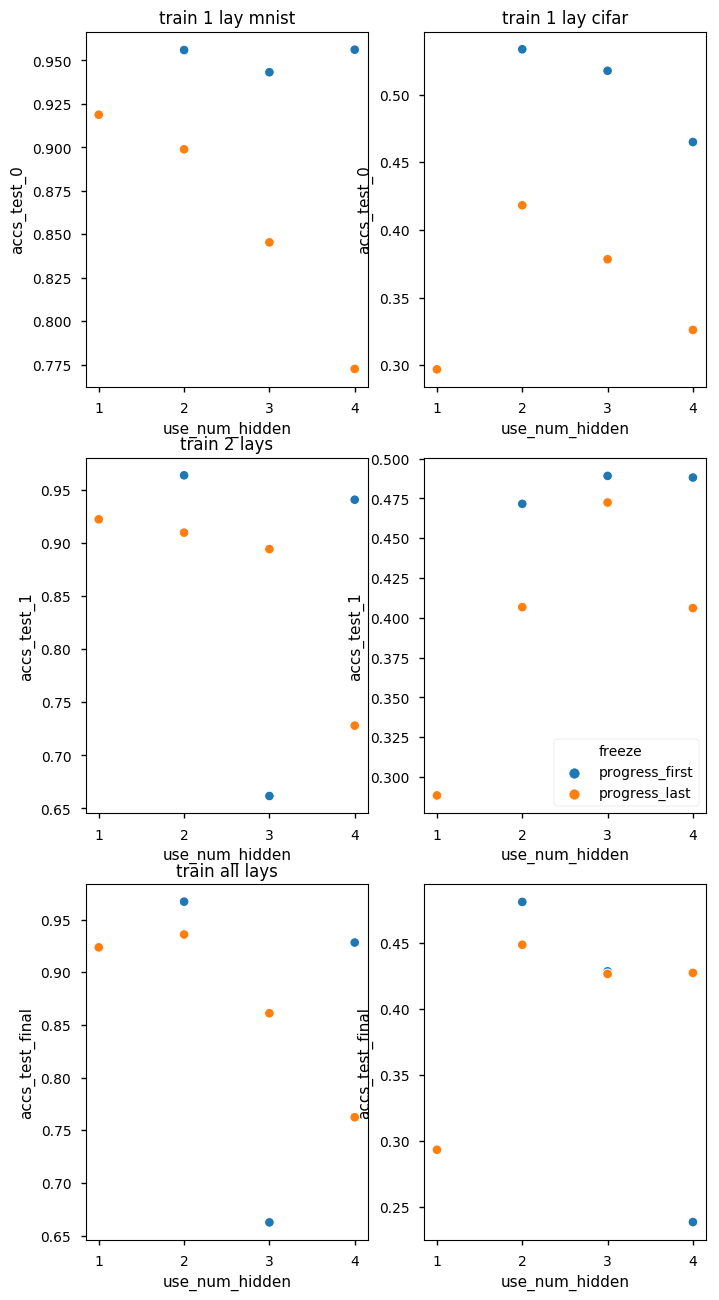

In [97]:
r = results.copy()
print('orig', r.shape)
# add accs to the correct layers
for lay, t in enumerate(np.arange(row['num_iters_small'] + row.lr_step, row.accs_test.size, row.lr_step)):
    r['accs_test_' + str(lay)] = np.array([x[t] for x in r['accs_test']])
    r['accs_test_final'] = np.array([x[-1] for x in r['accs_test']])

# mean over seeds
r = r.groupby(['lr', 'optimizer', 'use_num_hidden', 'dset', 'freeze']).mean().reset_index()

# get max over lr, optimizer
idx = r.groupby(['use_num_hidden', 'dset', 'freeze'])['accs_test_final'].transform(max) == r['accs_test_final']
r = r[idx]

# sort
r = r.sort_values(['dset', 'freeze', 'use_num_hidden'])
r = r[r['use_num_hidden'] <= 4]

R, C = 3, 2
plt.figure(facecolor='white', figsize=(8, 16), dpi=100)
plt.subplot(R, C, 1)
rm = r[r['dset'] == 'mnist']
plt.title('train 1 lay mnist')
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_0', hue='freeze', legend=False)

plt.subplot(R, C, 2)
rm = r[r['dset'] == 'cifar10']
plt.title('train 1 lay cifar')
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_0', hue='freeze', legend=False)

plt.subplot(R, C, 3)
plt.title('train 2 lays')
rm = r[r['dset'] == 'mnist']
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_1', hue='freeze', legend=False)

plt.subplot(R, C, 4)
rm = r[r['dset'] == 'cifar10']
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_1', hue='freeze', legend='brief')

plt.subplot(R, C, 5,)
plt.title('train all lays')
rm = r[r['dset'] == 'mnist']
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_final', hue='freeze', legend=False)

plt.subplot(R, C, 6)
rm = r[r['dset'] == 'cifar10']
sns.scatterplot(data=rm, x='use_num_hidden', y='accs_test_final', hue='freeze', legend=False)

plt.show()

# linears

In [ ]:
folder = 'mnist_linear'
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results_mnist = pd.concat(results_list, axis=1).T.infer_objects()


folder = 'cifar10_linear'
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results_cifar10 = pd.concat(results_list, axis=1).T.infer_objects()

# plot over num layers

In [ ]:
# print specials
for folder in ['mnist_conv_special', 'cifar10_conv', 'mnist_conv_lenet', 'cifar10_conv_special']:
    out_dir = oj(out_dir_main, folder)
    fnames = sorted(os.listdir(out_dir))
    results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
    results = pd.concat(results_list, axis=1).T.infer_objects()
    
    results['accs_test_final'] = np.array([x[-1] for x in results.accs_test])
    results['accs_train_final'] = np.array([x[-1] for x in results.accs_train])
    results_grouped = results.groupby(['lr', 'optimizer']).mean().reset_index()
    r = results_grouped["accs_test_final"]
    print(folder, f'test {np.max(r)}', 'train', np.max(results_grouped['accs_train_final']))
#     print('variability: ', results_grouped[['lr', 'optimizer', 'accs_test_final', 'accs_train_final']])

In [ ]:
plt.figure(facecolor='w', dpi=100)

R, C = 2, 2
cols = {0: 'cyan', 1: 'orange'} # 'freeze_all_but_first'
markers = {0: 'o', 1: 'x'}
# labels = {True: 'train first', False: 'train last'}

plt.subplot(R, C, 1)
labels = {x:x for x in set(results_mnist.hidden_size)}
r = results_mnist[results_mnist['freeze_all_but_first'] == True]
r['accs_test_final'] = np.array([x[-1] for x in r.accs_test])
for i, (col_index, group) in enumerate(r.groupby(['hidden_size'])):
    results_grouped = group.groupby(['use_num_hidden', 'lr']).mean().reset_index()
#     results_grouped_std = group.groupby(['use_num_hidden', 'lr']).std().reset_index()
    results_grouped = results_grouped.groupby('use_num_hidden').max().reset_index() # max over lr
    plt.errorbar(results_grouped['use_num_hidden'] + 0.05 * np.random.randn(results_grouped['use_num_hidden'].size), 
                 results_grouped['accs_test_final'], 
             fmt=markers[i], markeredgewidth=1, linestyle='--', c=cols[i], alpha=0.8, 
             label=labels[col_index], yerr=0)

plt.xlabel('num layers')    
plt.ylabel('final test acc')
plt.title('mnist')
plt.ylim((0.85, 1.0))
plt.xlim((.9, 4.1))
plt.legend()    


plt.subplot(R, C, 2)
labels = {x:x for x in set(results_cifar10.hidden_size)}
r = results_cifar10[results_cifar10['freeze_all_but_first'] == True]
r['accs_test_final'] = np.array([x[-1] for x in r.accs_test])
for i, (col_index, group) in enumerate(r.groupby(['hidden_size'])):
    results_grouped = group.groupby(['use_num_hidden', 'lr']).mean().reset_index()
#     results_grouped_std = group.groupby(['use_num_hidden', 'lr']).std().reset_index()
    results_grouped = results_grouped.groupby('use_num_hidden').max().reset_index() # max over lr
    plt.errorbar(results_grouped['use_num_hidden'] + 0.05 * np.random.randn(results_grouped['use_num_hidden'].size), 
                 results_grouped['accs_test_final'], 
             fmt=markers[i], markeredgewidth=1, linestyle='--', c=cols[i], alpha=0.8, 
             label=labels[col_index], yerr=0)

plt.xlabel('num layers')    
plt.title('cifar10')
# plt.ylim((0.85, 1.0))
plt.xlim((.9, 4.1))



plt.subplot(R, C, 3)
labels = {x:x for x in set(results_mnist.hidden_size)}
r = results_mnist[results_mnist['freeze_all_but_first'] == True]
r['accs_train_final'] = np.array([x[-1] for x in r.accs_train])
for i, (col_index, group) in enumerate(r.groupby(['hidden_size'])):
    results_grouped = group.groupby(['use_num_hidden', 'lr']).mean().reset_index()
#     results_grouped_std = group.groupby(['use_num_hidden', 'lr']).std().reset_index()
    results_grouped = results_grouped.groupby('use_num_hidden').max().reset_index() # max over lr
    plt.errorbar(results_grouped['use_num_hidden'] + 0.05 * np.random.randn(results_grouped['use_num_hidden'].size), 
                 results_grouped['accs_train_final'], 
             fmt=markers[i], markeredgewidth=1, linestyle='--', c=cols[i], alpha=0.8, 
             label=labels[col_index], yerr=0)

plt.xlabel('num layers')    
plt.ylabel('final train acc')
plt.ylim((0.85, 1.0))
plt.xlim((.9, 4.1))


plt.subplot(R, C, 4)
labels = {x:x for x in set(results_cifar10.hidden_size)}
r = results_cifar10[results_cifar10['freeze_all_but_first'] == True]
r['accs_train_final'] = np.array([x[-1] for x in r.accs_train])
for i, (col_index, group) in enumerate(r.groupby(['hidden_size'])):
    results_grouped = group.groupby(['use_num_hidden', 'lr']).mean().reset_index()
#     results_grouped_std = group.groupby(['use_num_hidden', 'lr']).std().reset_index()
    results_grouped = results_grouped.groupby('use_num_hidden').max().reset_index() # max over lr
    plt.errorbar(results_grouped['use_num_hidden'] + 0.05 * np.random.randn(results_grouped['use_num_hidden'].size), 
                 results_grouped['accs_train_final'], 
             fmt=markers[i], markeredgewidth=1, linestyle='--', c=cols[i], alpha=0.8, 
             label=labels[col_index], yerr=0)

plt.xlabel('num layers')    
# plt.ylim((0.85, 1.0))
plt.xlim((.9, 4.1))
plt.show()

# look at the weights

In [ ]:
# ['mnist_conv_special', 'mnist_conv_lenet', 'cifar10_conv', 'cifar10_conv_special', 'cifar10_linear', 'mnist_linear']

**load weights**

In [ ]:
folder = 'mnist_conv_special'
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()
# results.head()
# results_weights.dtypes

In [ ]:
w_dict = results_weights['weights'][0]
it = max(w_dict.keys())
w = w_dict[it]['fc.0.weight']
print(w.shape)
viz_weights.plot_weights(w)

In [ ]:
def save_final_weights(results_weights, results, out_dir='figs_special'):
    for optimizer in set(results_weights.optimizer): # 'sgd', 'adam'
        for lr in set(results_weights.lr): # lr 0.1, 0.01, 0.001
            for num_hidden in set(results_weights.use_num_hidden):
                try:
                    runs = results_weights[results_weights.lr==lr]
                    runs = runs[runs.optimizer==optimizer]
                    run = runs.iloc[0]
                    weight_dict = run.weights
                    min_key, max_key = min(weight_dict.keys()), max(weight_dict.keys())
                    weight_key = results.weight_names.iloc[0][0]
                    w = weight_dict[max_key][weight_key]
                    print(optimizer, lr, num_hidden)
                    viz_weights.plot_weights(w, run.dset)
                    plt.savefig(oj(out_dir, optimizer + '_' + 'lr=' + str(lr) + 'numh=' + str(num_hidden) + '.pdf'), 
                                   dpi=300, bbox_inches='tight')
                except Exception as e: print('err', optimizer, lr, e)
        
save_final_weights(results_weights, results)

In [ ]:
# note these norms were squared
# calculated via np.linalg.norm(weight_dict[lay_name])**2
viz_losses.plot_weight_norms_and_margin(results, out_dir='test')    

In [ ]:
all_w = ['explained_var_dicts_pca', 'explained_var_dicts_rbf', 'explained_var_dicts_lap', 'explained_var_dicts_cosine']
acts = ['act_var_dicts_train_pca', 'act_var_dicts_test_pca', 'act_var_dicts_train_rbf', 'act_var_dicts_test_rbf']
viz_losses.plot_dims_flexible(results, out_dir='test', xlim=None, dim_types=all_w, figname='ws')
# viz_losses.plot_dims(results, out_dir=save_dir, xlim=None, dim_types=all_w, figname='acts')    

In [ ]:
viz_losses.plot_losses(results_mnist, out_dir=save_dir)

just plot them all (this takes ~2 mins)

In [ ]:
viz_weights.save_final_weights(results_weights, results, out_dir='.')

In [ ]:
viz_weights.save_weight_evol(results_weights, out_dir='.')